In [6]:
import pandas as pd
import yfinance as yf
import numpy as np

actual_df = yf.download("SPY", start='2010-01-01', end='2024-11-26')
actual_df["Actual_Returns"] = actual_df['Adj Close']/actual_df['Adj Close'].shift(1) - 1
actual_df = actual_df.reset_index() 
actual_df["Date"] = pd.to_datetime(actual_df["Date"]).dt.tz_localize(None)

accuracy_dict = {}

roll_ls = [25, 50, 75, 100, 250, 500, 600, 700, 800 ,900, 1000]
for num in roll_ls:
    predictions_df = pd.read_csv(f"./data/rolling_window_predictions_{num}.csv")
    predictions_df["Date"] = pd.to_datetime(predictions_df["Date"]).dt.tz_localize(None)
    merged_df = pd.merge(actual_df, predictions_df, on="Date")
    merged_df = merged_df[["Actual_Returns", "Prediction"]]
    merged_df["corr_pred"] = np.where(np.sign(merged_df["Actual_Returns"]) == np.sign(merged_df["Prediction"]), 1, 0 )
    accuracy = (merged_df[merged_df["corr_pred"] == 1]["corr_pred"].sum())/len(merged_df)
    accuracy_dict[num] = accuracy


[*********************100%***********************]  1 of 1 completed


In [7]:
accuracy_dict

{25: 0.5060088551549652,
 50: 0.5160668380462725,
 75: 0.5022860875244938,
 100: 0.5166002656042497,
 250: 0.5228613569321534,
 500: 0.5226039783001808,
 600: 0.49654491609081935,
 700: 0.5082146768893757,
 800: 0.45141451414514144,
 900: 0.5091164095371669,
 1000: 0.5}

[*********************100%***********************]  1 of 1 completed


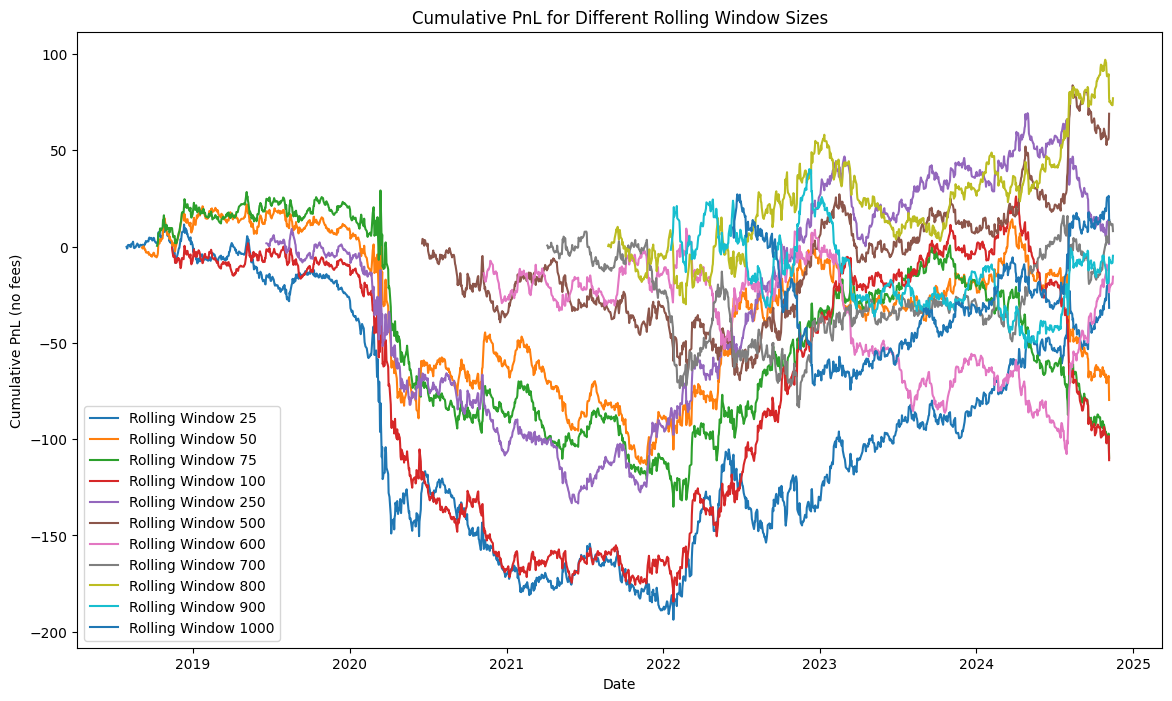

In [8]:
import matplotlib.pyplot as plt
backtest_df = yf.download("SPY", start='2010-01-01', end='2024-11-16')
backtest_df = backtest_df.reset_index() 
backtest_df["Date"] = pd.to_datetime(backtest_df["Date"]).dt.tz_localize(None)

plt.figure(figsize=(14, 8))

roll_ls = [25, 50, 75, 100, 250, 500, 600, 700, 800 ,900, 1000]
for num in roll_ls:
    predictions_df = pd.read_csv(f"./data/rolling_window_predictions_{num}.csv")
    predictions_df["Date"] = pd.to_datetime(predictions_df["Date"]).dt.tz_localize(None)
    predictions_df["Prediction"] = predictions_df["Prediction"]/100
    merged_df = pd.merge(backtest_df, predictions_df, on="Date")
    merged_df["trade_signal"] = np.where(merged_df["Prediction"] > 0, 1, (np.where(merged_df["Prediction"] < 0, -1, 0)))
    merged_df["PnL_no_fees"] = merged_df["trade_signal"] * (merged_df["Close"].shift(1) - merged_df["Open"])
    merged_df["cum_PnL_no_fees"] = merged_df["PnL_no_fees"].cumsum()
    plt.plot(merged_df["Date"], merged_df["cum_PnL_no_fees"], label=f'Rolling Window {num}')
    
# Add legend and labels
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (no fees)")
plt.title("Cumulative PnL for Different Rolling Window Sizes")
plt.show()
